# Stream Data from a .csv 

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
# from scipy.signal import butter, filtfilt, lfilter
from scipy import signal
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.append("..") # So that it can find the modules
# Assuming the other modules (brainflow_stream, filtering, segmentation, classification) are available
from modules.brainflow_stream import *
from modules.filtering import *
from modules.segmentation import *

from modules.ssvep_stim import *

from modules.visualization import *
# from modules.classification import *

pygame 2.5.2 (SDL 2.28.3, Python 3.8.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Setting variables:
board_id = BoardIds.CYTON_BOARD.value # BoardIds.SYNTHETIC_BOARD.value 
frequencies = [9.25, 11.25, 13.25, 15.25]
buttons = ['Right', 'Left', 'Up', 'Down']
button_pos = [0, 2, 3, 1]
display = 0
segment_duration = 3

# Static Variables - Probably don't need to touch :)
harmonics = 3 # np.arange(1, 4) # Generates the 1st, 2nd, & 3rd Harmonics
sampling_rate = BoardShim.get_sampling_rate(board_id)
n_samples = sampling_rate * segment_duration

In [4]:
import numpy as np
from sklearn.cross_decomposition import CCA

def generate_reference_signals(frequencies, harmonics, sample_rate, n_samples):
    """Generate sine/cosine reference signals for each frequency and harmonic."""
    t = np.arange(n_samples) / sample_rate
    reference_signals = {}
    
    for f in frequencies:
        ref = []
        for h in range(1, harmonics + 1):
            ref.append(np.sin(2 * np.pi * f * h * t))
            ref.append(np.cos(2 * np.pi * f * h * t))
        reference_signals[f] = np.array(ref)
    
    return reference_signals

def cca_ssvep(eeg_data, reference_signals):
    """Apply CCA to find the SSVEP frequency with highest correlation."""
    # Transpose eeg_data to have shape (n_samples, n_channels)
    eeg_data = eeg_data.T
    
    cca = CCA(n_components=1)
    max_corr = 0
    detected_freq = None
    
    for f, ref_signal in reference_signals.items():
        # Transpose the reference signal to (samples, harmonics * 2)
        ref_signal = ref_signal.T
        
        # Apply CCA between EEG data and reference signal
        cca.fit(eeg_data, ref_signal)
        U, V = cca.fit_transform(eeg_data, ref_signal)
        corr = np.corrcoef(U.T, V.T)[0, 1]
        
        # Update max correlation and detected frequency
        if corr > max_corr:
            max_corr = corr
            detected_freq = f
    
    return detected_freq, max_corr


In [9]:
import numpy as np
from typing import List, Union
from scipy import linalg

class SSVEPClassifier:
    def __init__(self, 
                 sampling_rate: int = 250, 
                 num_harms: int = 3):
        """
        Initialize SSVEP classifier
        
        Parameters:
        -----------
        sampling_rate : int, optional
            Sampling rate of the EEG data (default 250 Hz)
        num_harms : int, optional
            Number of harmonic frequencies to use (default 3)
        """
        self.sampling_rate = sampling_rate
        self.num_harms = num_harms
        self.reference_signals = {}
    
    def _generate_reference_signals(self, 
                                    frequency: float) -> np.ndarray:
        """
        Generate reference signals for a given frequency
        
        Parameters:
        -----------
        frequency : float
            Target stimulation frequency
        
        Returns:
        --------
        np.ndarray
            Reference signals matrix
        """
        # Time vector
        t = np.arange(0, 1, 1/self.sampling_rate)
        
        # Initialize reference signals matrix
        ref_signals = []
        
        # Generate sine and cosine harmonics
        for h in range(1, self.num_harms + 1):
            ref_signals.append(np.sin(2 * np.pi * h * frequency * t))
            ref_signals.append(np.cos(2 * np.pi * h * frequency * t))
        
        return np.array(ref_signals)
    
    def fit(self, 
            target_frequencies: List[float]) -> None:
        """
        Prepare reference signals for target frequencies
        
        Parameters:
        -----------
        target_frequencies : List[float]
            List of target stimulation frequencies
        """
        # Generate and store reference signals for each frequency
        self.reference_signals = {
            freq: self._generate_reference_signals(freq) 
            for freq in target_frequencies
        }
        self.target_frequencies = target_frequencies
    
    def _cca_classify(self, 
                      data: np.ndarray, 
                      ref_signals: np.ndarray) -> float:
        """
        Perform Canonical Correlation Analysis (CCA)
        
        Parameters:
        -----------
        data : np.ndarray
            Input signal (n_samples, n_channels)
        ref_signals : np.ndarray
            Reference signals matrix
        
        Returns:
        --------
        float
            Maximum canonical correlation
        """
        # Ensure data is 2D
        if data.ndim == 1:
            data = data.reshape(1, -1)
        
        # Standardize data
        data_mean = data - np.mean(data, axis=0)
        ref_mean = ref_signals - np.mean(ref_signals, axis=0)
        
        # Compute correlation
        try:
            # Perform CCA
            A = data_mean.T @ ref_mean
            U, S, VT = linalg.svd(A)
            
            # Return maximum canonical correlation
            return np.max(S)
        except Exception as e:
            print(f"CCA Error: {e}")
            return 0.0
    
    def predict(self, 
                data: np.ndarray) -> Union[int, np.ndarray]:
        """
        Predict SSVEP class for input data
        
        Parameters:
        -----------
        data : np.ndarray
            Input signal(s) to classify 
            Shape: (n_samples, n_channels) or (n_trials, n_samples, n_channels)
        
        Returns:
        --------
        int or np.ndarray
            Predicted class index/indices
        """
        # Handle multiple input formats
        if data.ndim == 2:
            data = data.reshape(1, *data.shape)
        
        # Compute correlations for each trial and frequency
        correlations = np.zeros((data.shape[0], len(self.target_frequencies)))
        
        for i, trial in enumerate(data):
            for j, (freq, ref_signals) in enumerate(self.reference_signals.items()):
                correlations[i, j] = self._cca_classify(trial, ref_signals)
        
        # Return class indices with maximum correlation
        return correlations.argmax(axis=1)

In [ ]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

filter_obj = Filtering(sampling_rate)

time.sleep(10)

segment = board.get_current_board_data(num_samples=n_samples)


eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels

filtered_segment_notch = filter_obj.notch_filter(eeg_segment, notch_freq=60)

filtered_segment_bp = filter_obj.bandpass_filter(filtered_segment_notch, highcut=30, lowcut=5, order=4)

filtered_segment_norm = (filtered_segment_bp - np.mean(filtered_segment_bp, axis=1, keepdims=True)) / np.std(filtered_segment_bp, axis=1, keepdims=True)

# Modify the CCA method to correctly handle the input shape
class SSVEPClassifier:
    def __init__(self, sampling_rate=250, num_harms=3):
        self.sampling_rate = sampling_rate
        self.num_harms = num_harms
        self.reference_signals = {}
        self.target_frequencies = []
    
    def _generate_reference_signals(self, frequency, signal_length):
        """
        Generate reference signals with a specific length
        
        Parameters:
        -----------
        frequency : float
            Target frequency
        signal_length : int
            Length of the signal to generate
        
        Returns:
        --------
        np.ndarray
            Reference signals for the given frequency
        """
        # Create time array matching the signal length
        t = np.linspace(0, 1, signal_length, endpoint=False)
        
        ref_signals = []
        for h in range(1, self.num_harms + 1):
            ref_signals.append(np.sin(2 * np.pi * h * frequency * t))
            ref_signals.append(np.cos(2 * np.pi * h * frequency * t))
        
        return np.array(ref_signals)
    
    def fit(self, target_frequencies):
        """
        Prepare reference signals for target frequencies
        
        Parameters:
        -----------
        target_frequencies : list
            List of target stimulus frequencies
        """
        self.target_frequencies = target_frequencies
        self.reference_signals = {}
    
    def _cca_classify(self, data, freq, signal_length):
        """
        Perform Canonical Correlation Analysis (CCA) classification
        
        Parameters:
        -----------
        data : np.ndarray
            Input EEG data (channels x samples)
        freq : float
            Target frequency
        signal_length : int
            Length of the signal segment
        
        Returns:
        --------
        float
            Maximum correlation score
        """
        try:
            # Ensure data is 2D (channels x samples)
            if data.ndim == 1:
                data = data.reshape(1, -1)
            
            # Generate reference signals matching data length
            ref_signals = self._generate_reference_signals(freq, signal_length)
            
            # Compute correlation between data and reference signals
            correlations = []
            for i in range(ref_signals.shape[0]):
                ref_signal = ref_signals[i, :]
                
                # Compute correlation for each channel
                channel_correlations = [np.corrcoef(channel, ref_signal)[0, 1] 
                                        for channel in data]
                correlations.append(np.max(np.abs(channel_correlations)))
            
            return np.max(correlations)
        except Exception as e:
            print(f"CCA Error for frequency {freq}: {e}")
            return 0.0
    
    def predict(self, data):
        """
        Predict the most likely stimulus frequency
        
        Parameters:
        -----------
        data : np.ndarray
            Input EEG data segment (channels x samples)
        
        Returns:
        --------
        int
            Index of the predicted stimulus frequency
        """
        if data.shape[1] == 0:
            raise ValueError("Input data segment is empty")
        
        # Determine signal length from input data
        signal_length = data.shape[1]
        
        correlations = np.zeros(len(self.target_frequencies))
        
        for j, freq in enumerate(self.target_frequencies):
            correlations[j] = self._cca_classify(data, freq, signal_length)
        
        return np.argmax(correlations)

# Prepare labels (assuming 4 different stimuli)
y = np.array(actual_freqs) #np.array([0, 1, 2, 3])
print(y)
# Initialize classifier
classifier = SSVEPClassifier(sampling_rate=250)
classifier.fit(actual_freqs)

# Predict
y_pred = classifier.predict(filtered_segment_norm)
# np.array([classifier.predict(filtered_segment_norm[:, i*n_samples//4:(i+1)*n_samples//4]) 
                #    for i in range(4)])

print(actual_freqs[y_pred])
# Compute accuracy
accuracy = np.mean(y_pred == y)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

[Board 7, ] Streaming stopped.
[Board 7, ] Session released.
[Board 8, ] Board setup and streaming started successfully.
Actual Frequencies: [9.23, 11.43, 13.33, 15.0]
3
Classification Accuracy: 0.00%


#

[Board 2, ] Streaming stopped.
[Board 2, ] Session released.
[Board 3, ] Board setup and streaming started successfully.
Actual Frequencies: [9.23, 11.43, 13.33, 15.0]


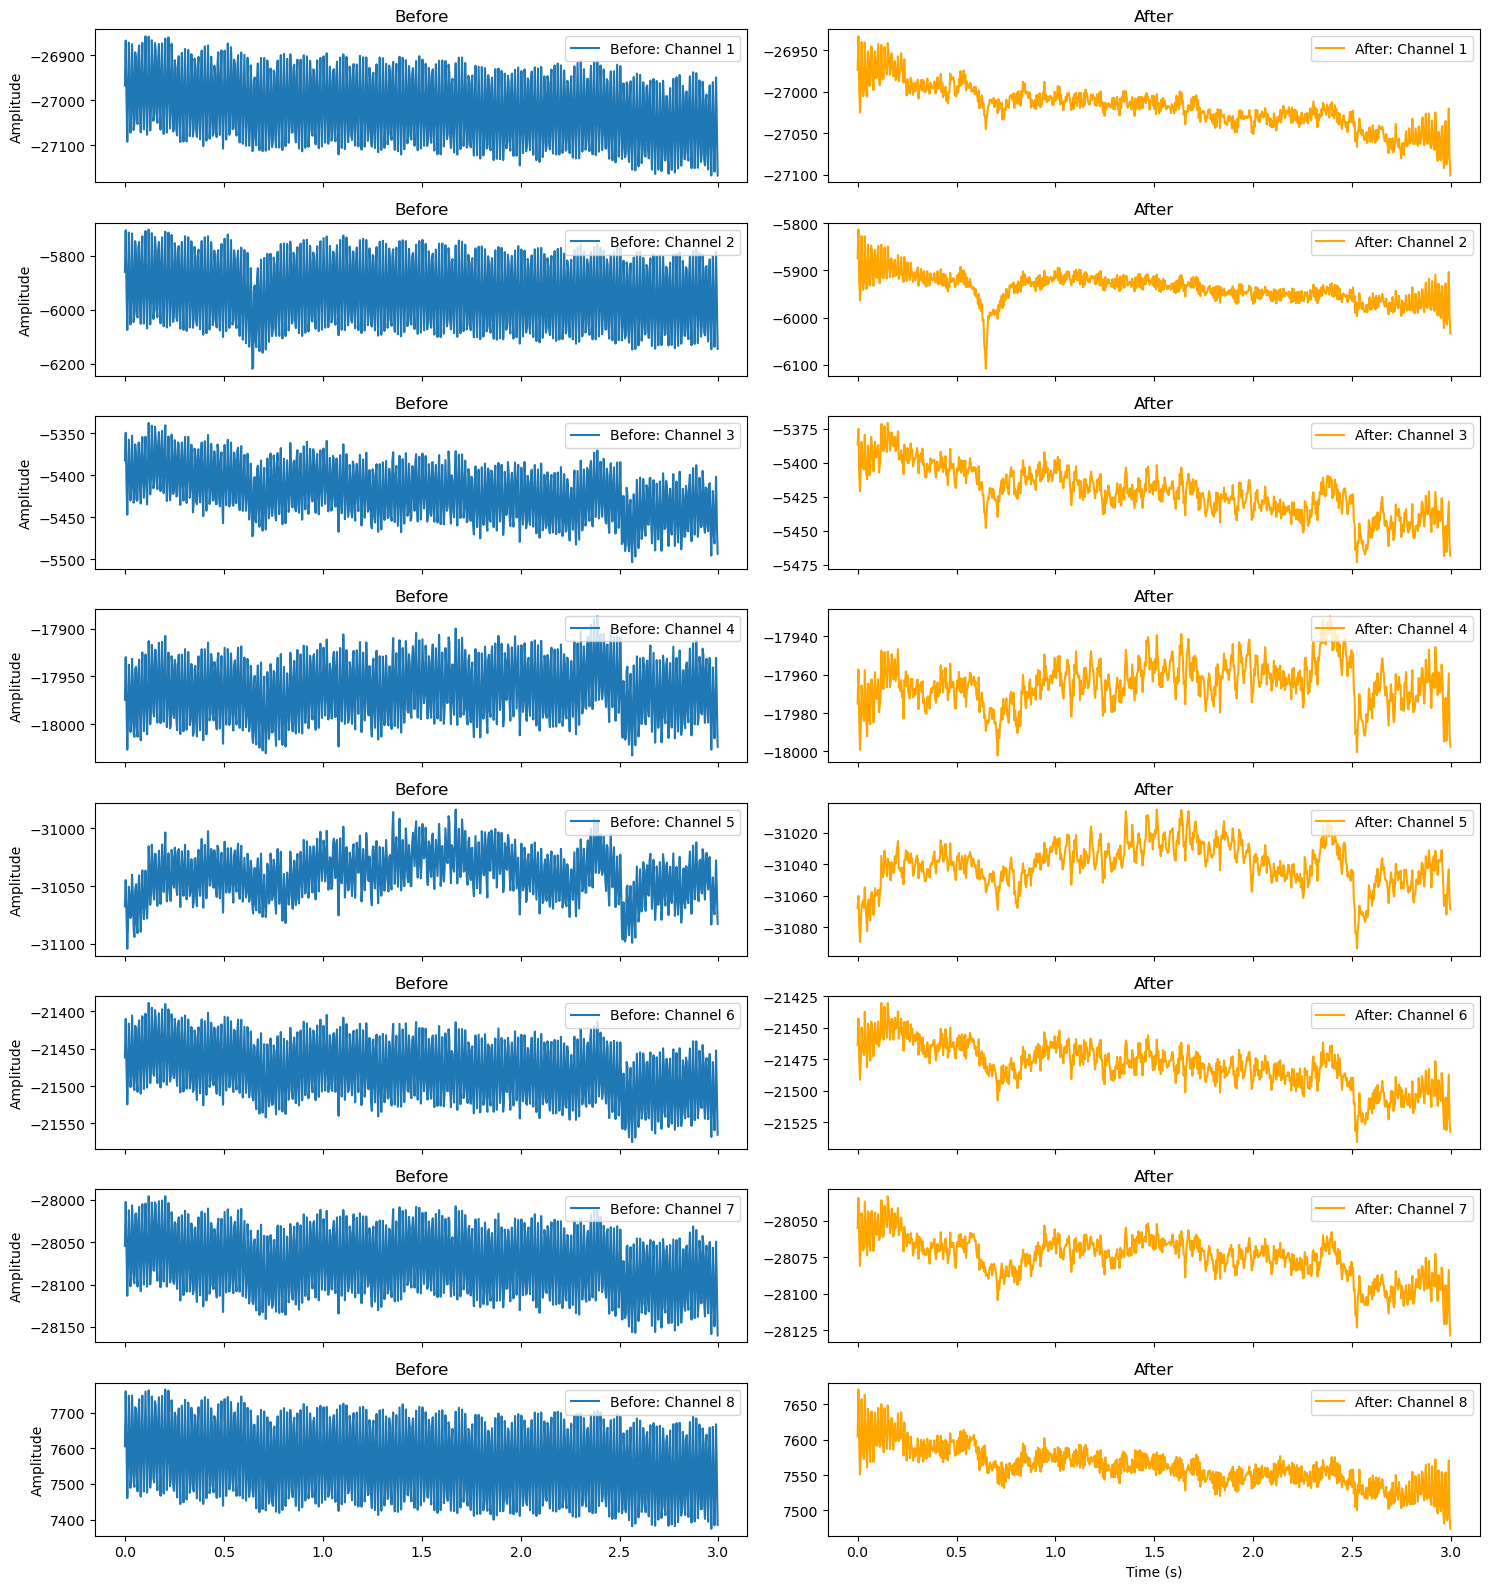

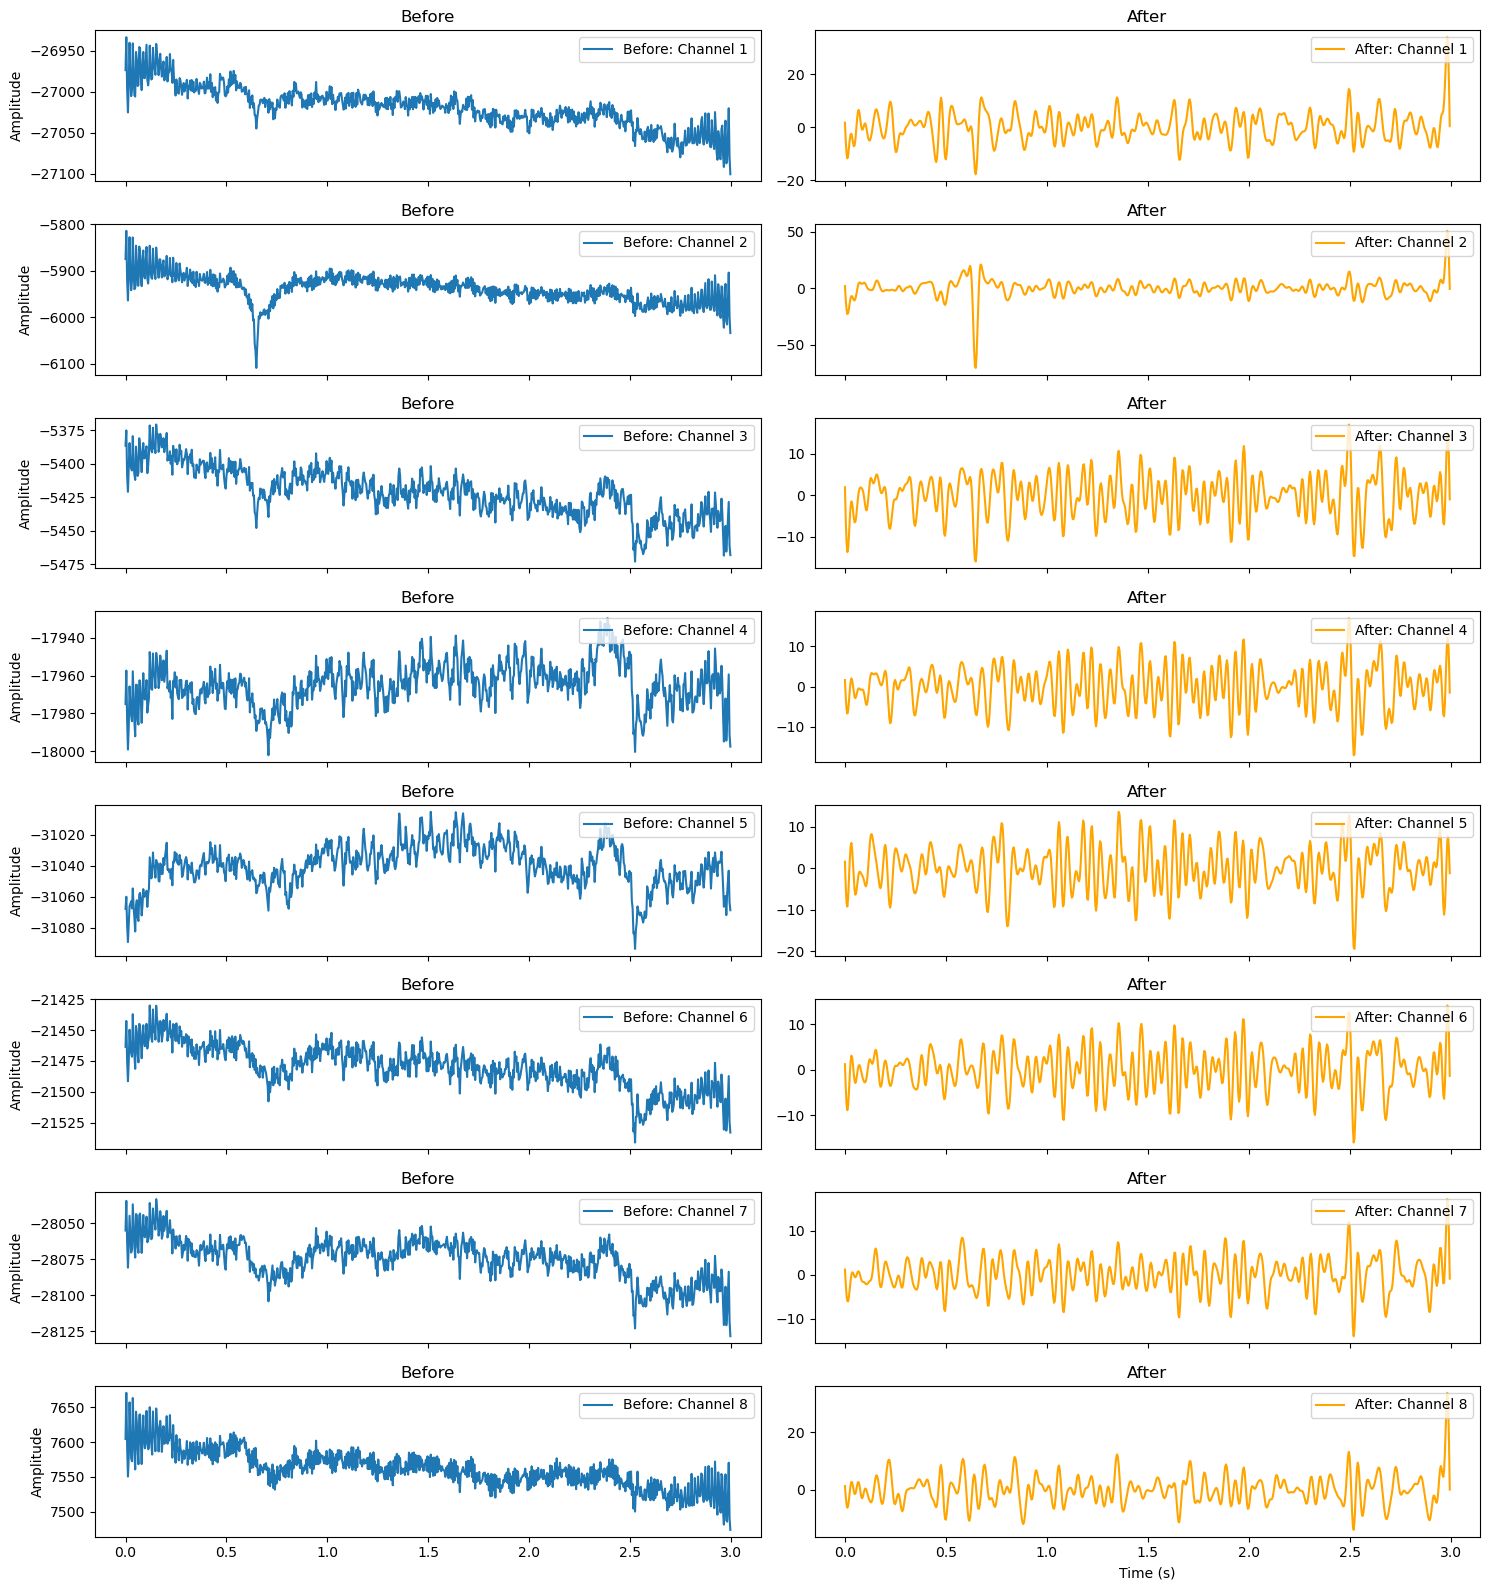

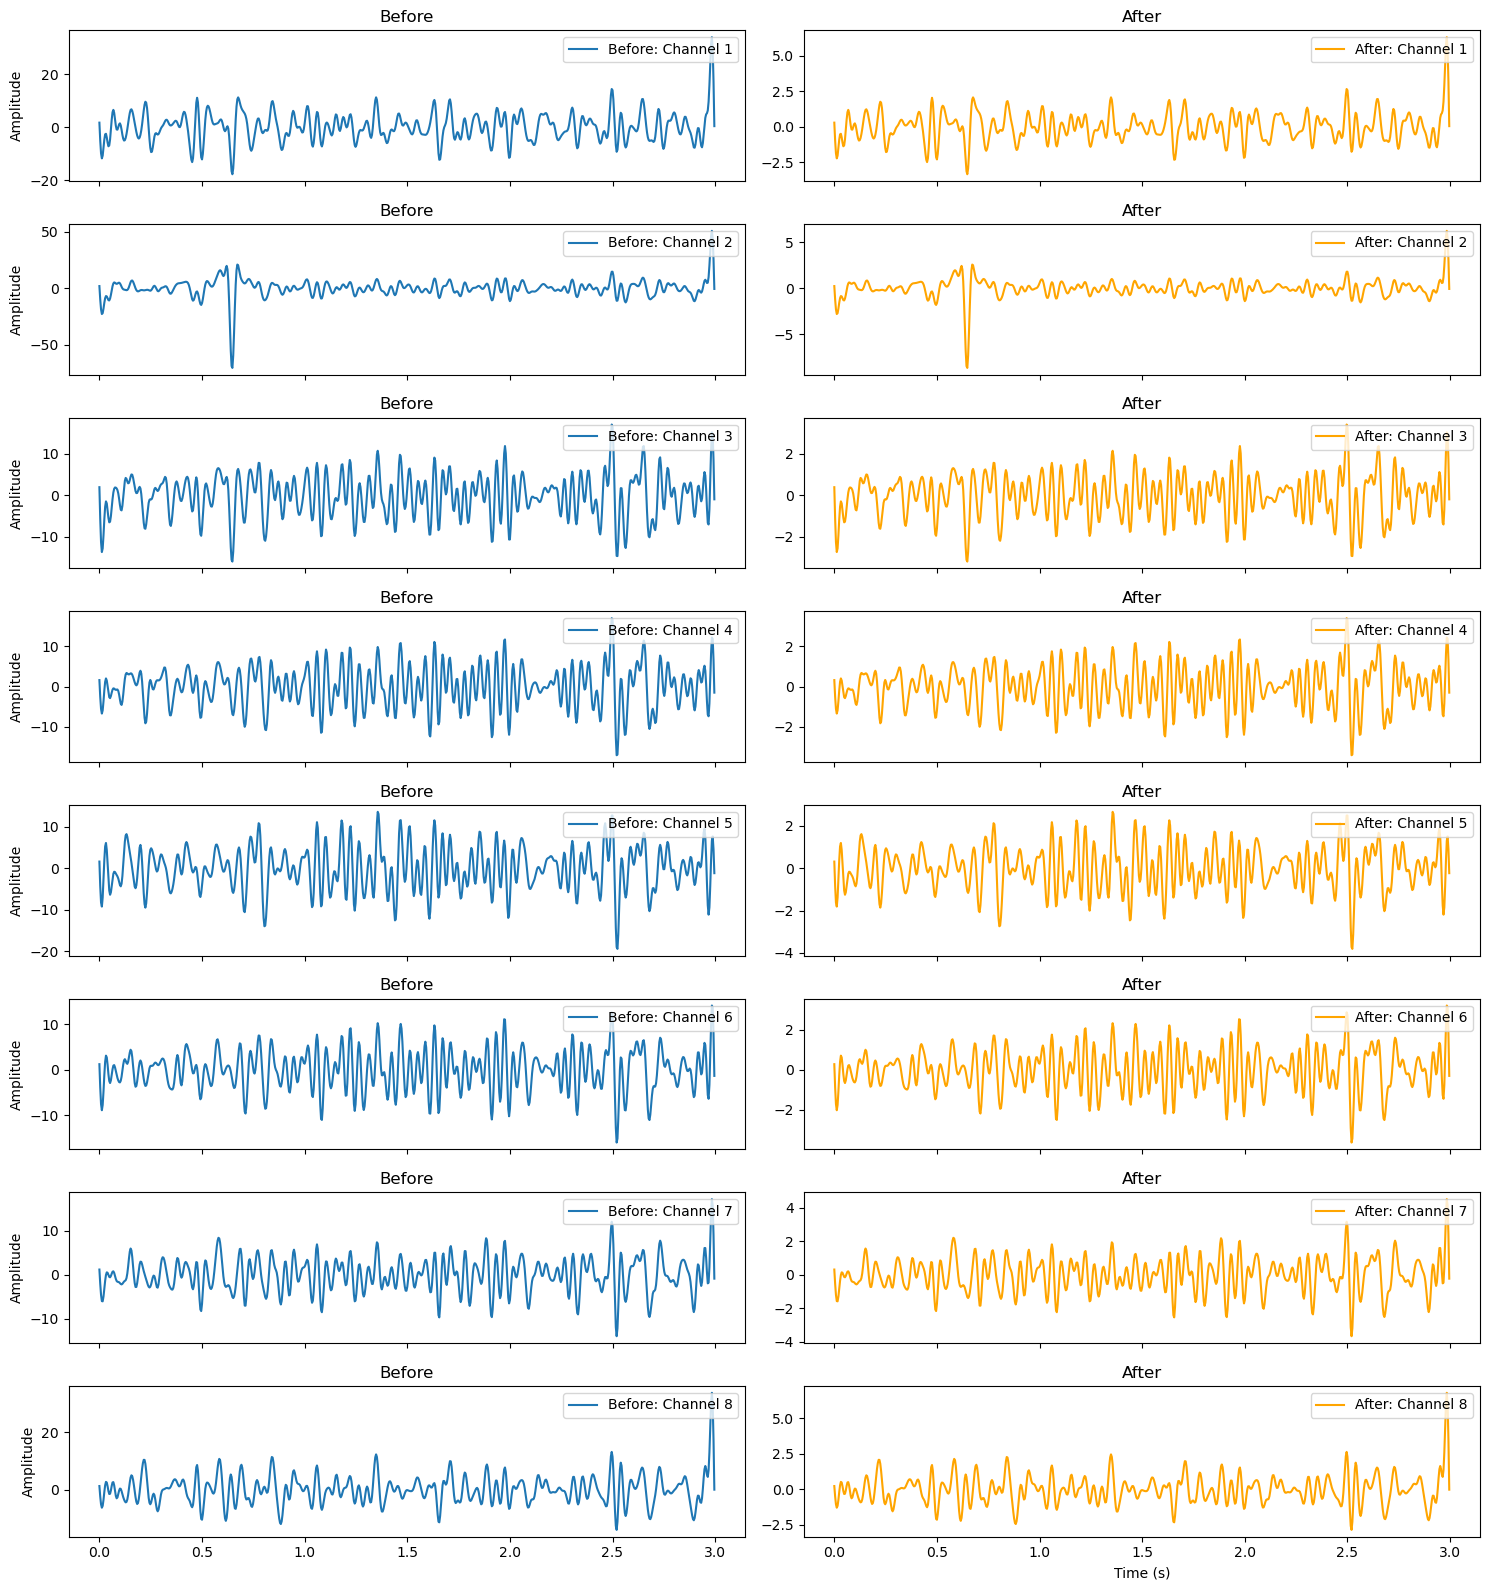

NameError: name 'generate_reference_signals' is not defined

In [7]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

filter_obj = Filtering(sampling_rate)

time.sleep(5)

while True:
    segment = board.get_current_board_data(num_samples=n_samples)
    eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels

    filtered_segment_notch = filter_obj.notch_filter(eeg_segment, notch_freq=60)

    compare_eeg_time_series(eeg_segment, filtered_segment_notch, sampling_rate=sampling_rate)

    filtered_segment_bp = filter_obj.bandpass_filter(filtered_segment_notch, highcut=30, lowcut=5, order=4)

    compare_eeg_time_series(filtered_segment_notch, filtered_segment_bp, sampling_rate=sampling_rate)

    # filtered_segment_norm = filtered_segment_bp / np.max(np.abs(filtered_segment_bp))
    filtered_segment_norm = (filtered_segment_bp - np.mean(filtered_segment_bp, axis=1, keepdims=True)) / np.std(filtered_segment_bp, axis=1, keepdims=True)

    compare_eeg_time_series(filtered_segment_bp, filtered_segment_norm, sampling_rate=sampling_rate)

    # print(filtered_segment.shape)

    reference_signals = generate_reference_signals(frequencies=actual_freqs, 
                                                    harmonics=harmonics, 
                                                    sample_rate=sampling_rate, 
                                                    n_samples=n_samples)
    
    # compare_eeg_time_series(filtered_segment_norm, reference_signals[9.23], sampling_rate=sampling_rate)   

    detected_freq, correlation = cca_ssvep(eeg_data=filtered_segment_norm, 
                                            reference_signals=reference_signals)

    print(f"Detected Frequency: {detected_freq} Hz with correlation: {correlation}")

    # board.stop()

    # Wait for the next segment of data
    time.sleep(segment_duration)

## Testing

In [6]:
import numpy as np
import hashlib
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

filter_obj = Filtering(sampling_rate)

time.sleep(15)
# Initialize the previous segment hash and correlation threshold
previous_hash = None
correlation_threshold = 0.3  # Set based on your needs for a "significant" correlation

while True:
    # Get current segment and hash it to detect changes
    segment = board.get_current_board_data(num_samples=n_samples)
    current_hash = hashlib.md5(segment.tobytes()).hexdigest()

    if current_hash != previous_hash:
        # Only proceed if the segment is new
        previous_hash = current_hash
        eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels
        
        filtered_segment = filter_obj.notch_filter(eeg_segment, notch_freq=60)
        
        filtered_segment = filter_obj.bandpass_filter(filtered_segment, highcut=30, lowcut=5, order=4)
        
        filtered_segment = filtered_segment / np.max(np.abs(filtered_segment))
        
        reference_signals = generate_reference_signals(
            frequencies=actual_freqs, 
            harmonics=harmonics, 
            sample_rate=sampling_rate, 
            n_samples=n_samples
        )

        detected_freq, correlation = cca_ssvep(eeg_data=filtered_segment, reference_signals=reference_signals)
        
        # Apply thresholding to avoid low-correlation outputs
        if correlation > correlation_threshold:
            print(f"Detected Frequency: {detected_freq} Hz with correlation: {correlation}")
    else:
        print("No new data detected, skipping iteration.")

    # Wait for the next segment of data
    time.sleep(segment_duration)


[Board 0, ] Board setup and streaming started successfully.
Actual Frequencies: [9.23, 11.43, 13.33, 15.0]
Detected Frequency: 11.43 Hz with correlation: 0.41202204180759444
Detected Frequency: 9.23 Hz with correlation: 0.45425522533368234
Detected Frequency: 9.23 Hz with correlation: 0.4047878843615567
Detected Frequency: 9.23 Hz with correlation: 0.3786974935753659
Detected Frequency: 9.23 Hz with correlation: 0.32101439033248275
Detected Frequency: 13.33 Hz with correlation: 0.4047819513276648
Detected Frequency: 13.33 Hz with correlation: 0.4560338676498449
Detected Frequency: 11.43 Hz with correlation: 0.31494579245246385
Detected Frequency: 15.0 Hz with correlation: 0.37554148869732373
Detected Frequency: 9.23 Hz with correlation: 0.415306707569982


KeyboardInterrupt: 

In [7]:
board.stop()

[Board 0, ] Streaming stopped.
[Board 0, ] Session released.


# ALSO OLD

In [5]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

cca_classifier = SSVEPClassifier(frequencies=actual_freqs, 
                                win_len=segment_duration, 
                                s_rate=sampling_rate)

filter_obj = Filtering(sampling_rate)

time.sleep(15)

while True:
    segment = board.get_current_board_data(num_samples=n_samples)
    eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels
            
    # Apply bandpass filter
    filtered_segment = filter_obj.bandpass_filter(dc_offset_removed, highcut=30, lowcut=0.1, order=4)

    r = cca_classifier(filtered_segment) 
    print(r)
    
    # visualize_all_channels_plotly(eeg_segment, filtered_segment)
    
    # Check signal alignment for the first frequency
    # reference_signal = cca_classifier.reference_signals[0]  # First frequency reference
    # check_signal_alignment(filtered_segment, reference_signal)

    # Compare one EEG channel (Channel 1) against reference signal for the first frequency
    # visualize_reference_vs_eeg(filtered_segment, reference_signal, actual_freqs[0])
    
    

    # Perform classification using the filtered EEG data
    # correlations = []
    # for freq_idx, freq in enumerate(actual_freqs):
    #     detected_freq, correlation = cca_classifier(filtered_segment)
    #     correlations.append(correlation)
    #     print(f"Frequency: {freq} Hz, Correlation: {correlation}")

    # Plot correlation coefficients across frequencies (optional, uncomment if needed)
    # plot_correlation_across_frequencies(actual_freqs, correlations)
    


    # Wait for the next segment of data
    time.sleep(segment_duration)

[Board 1, ] Board setup and streaming started successfully.
Actual Frequencies: [9.23, 11.43, 13.33, 15.0]


TypeError: __init__() got an unexpected keyword argument 'win_len'

## OLDER CODE

In [4]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

# board.board_config('/2')

# Let data accumulate
time.sleep(15)

raw_data = board.get_current_board_data(num_samples = n_samples)
eeg_data = raw_data[1:9, :] # Removing the timestamp column
eeg_data.shape
board.stop()

[Board 0, ] Board setup and streaming started successfully.
[Board 0, ] Streaming stopped.
[Board 0, ] Session released.


In [5]:
timestamps = raw_data[22, :]
package_nums = raw_data[0]

In [6]:
filter_obj = Filtering(sampling_rate)

filtered_data = filter_obj.bandpass_filter(eeg_data, highcut=30, lowcut=5, order=8)

channel_names = board.get_eeg_names(board_id=board_id)

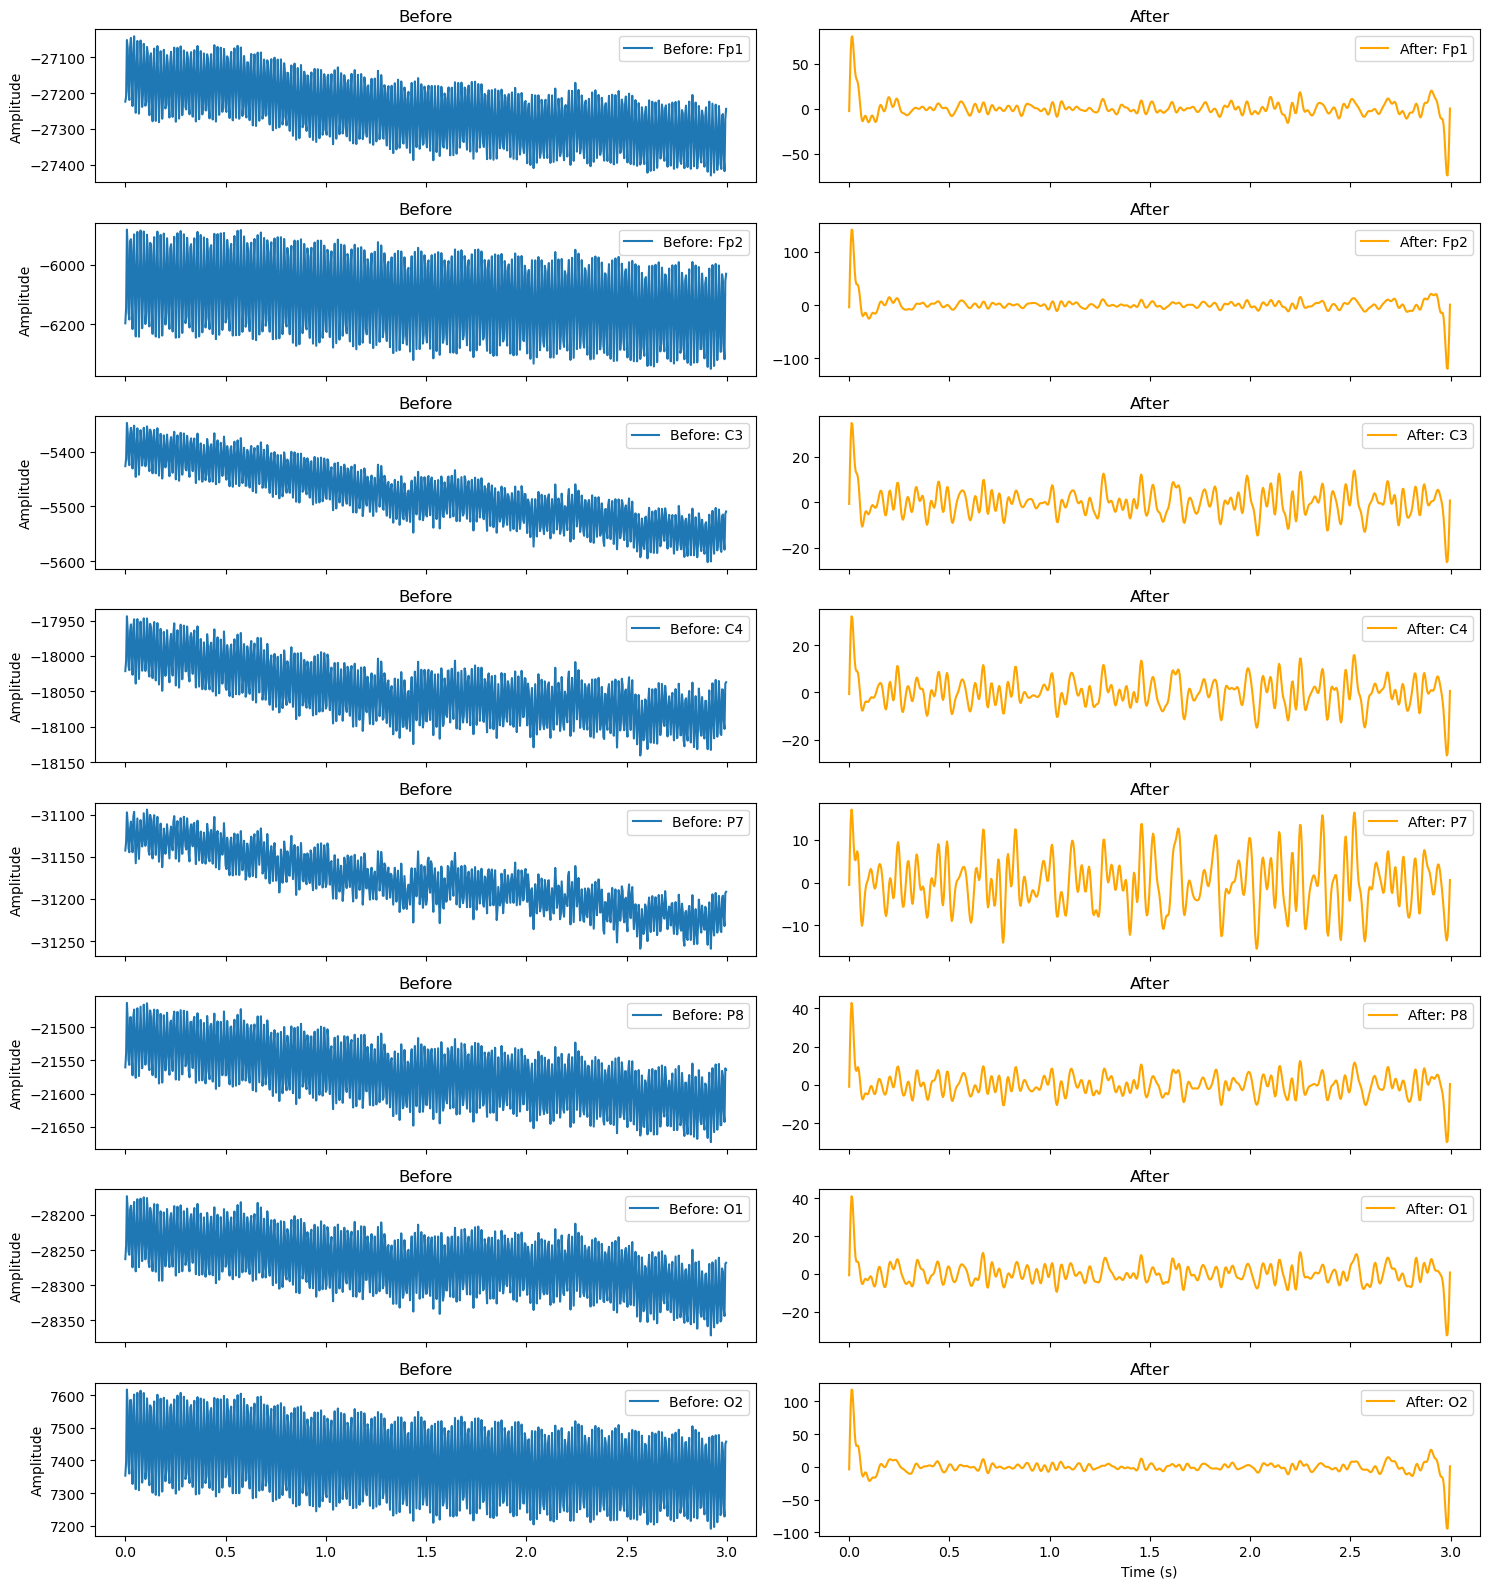

In [10]:
compare_eeg_time_series(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

c:\Users\surge\miniforge3\envs\stealthneuro\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 750, using nperseg = 750
  warnings.warn('nperseg = {0:d} is greater than input length '


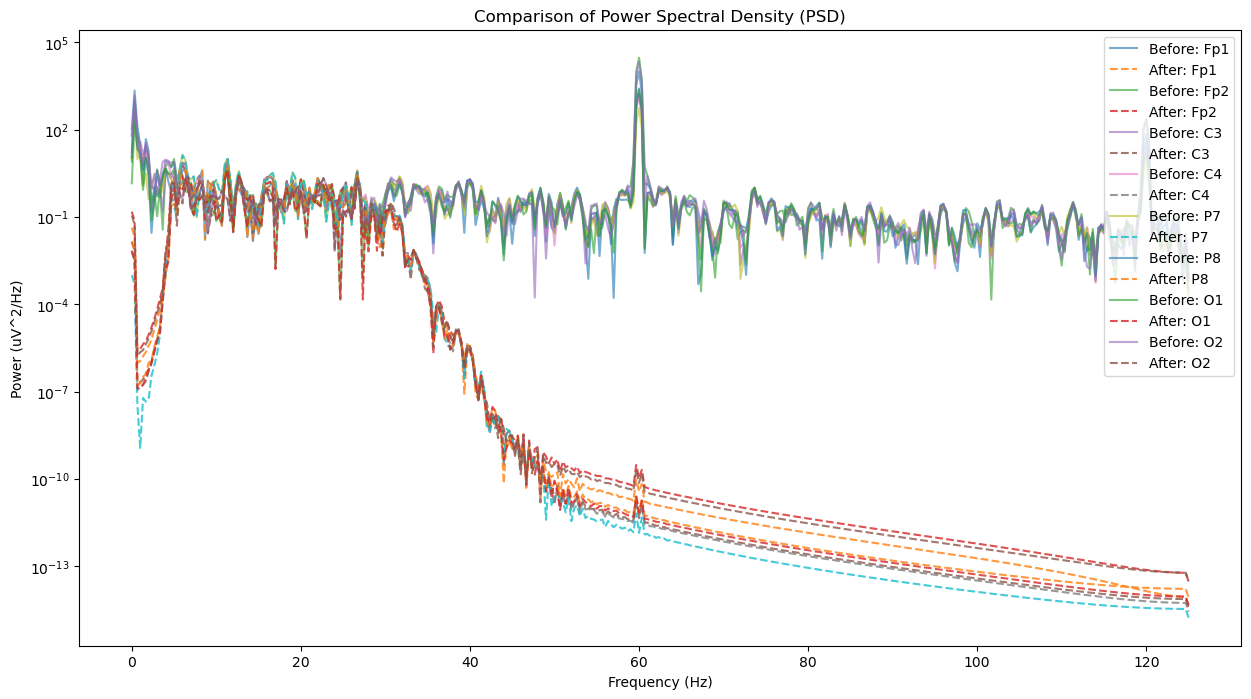

In [11]:
compare_psd(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

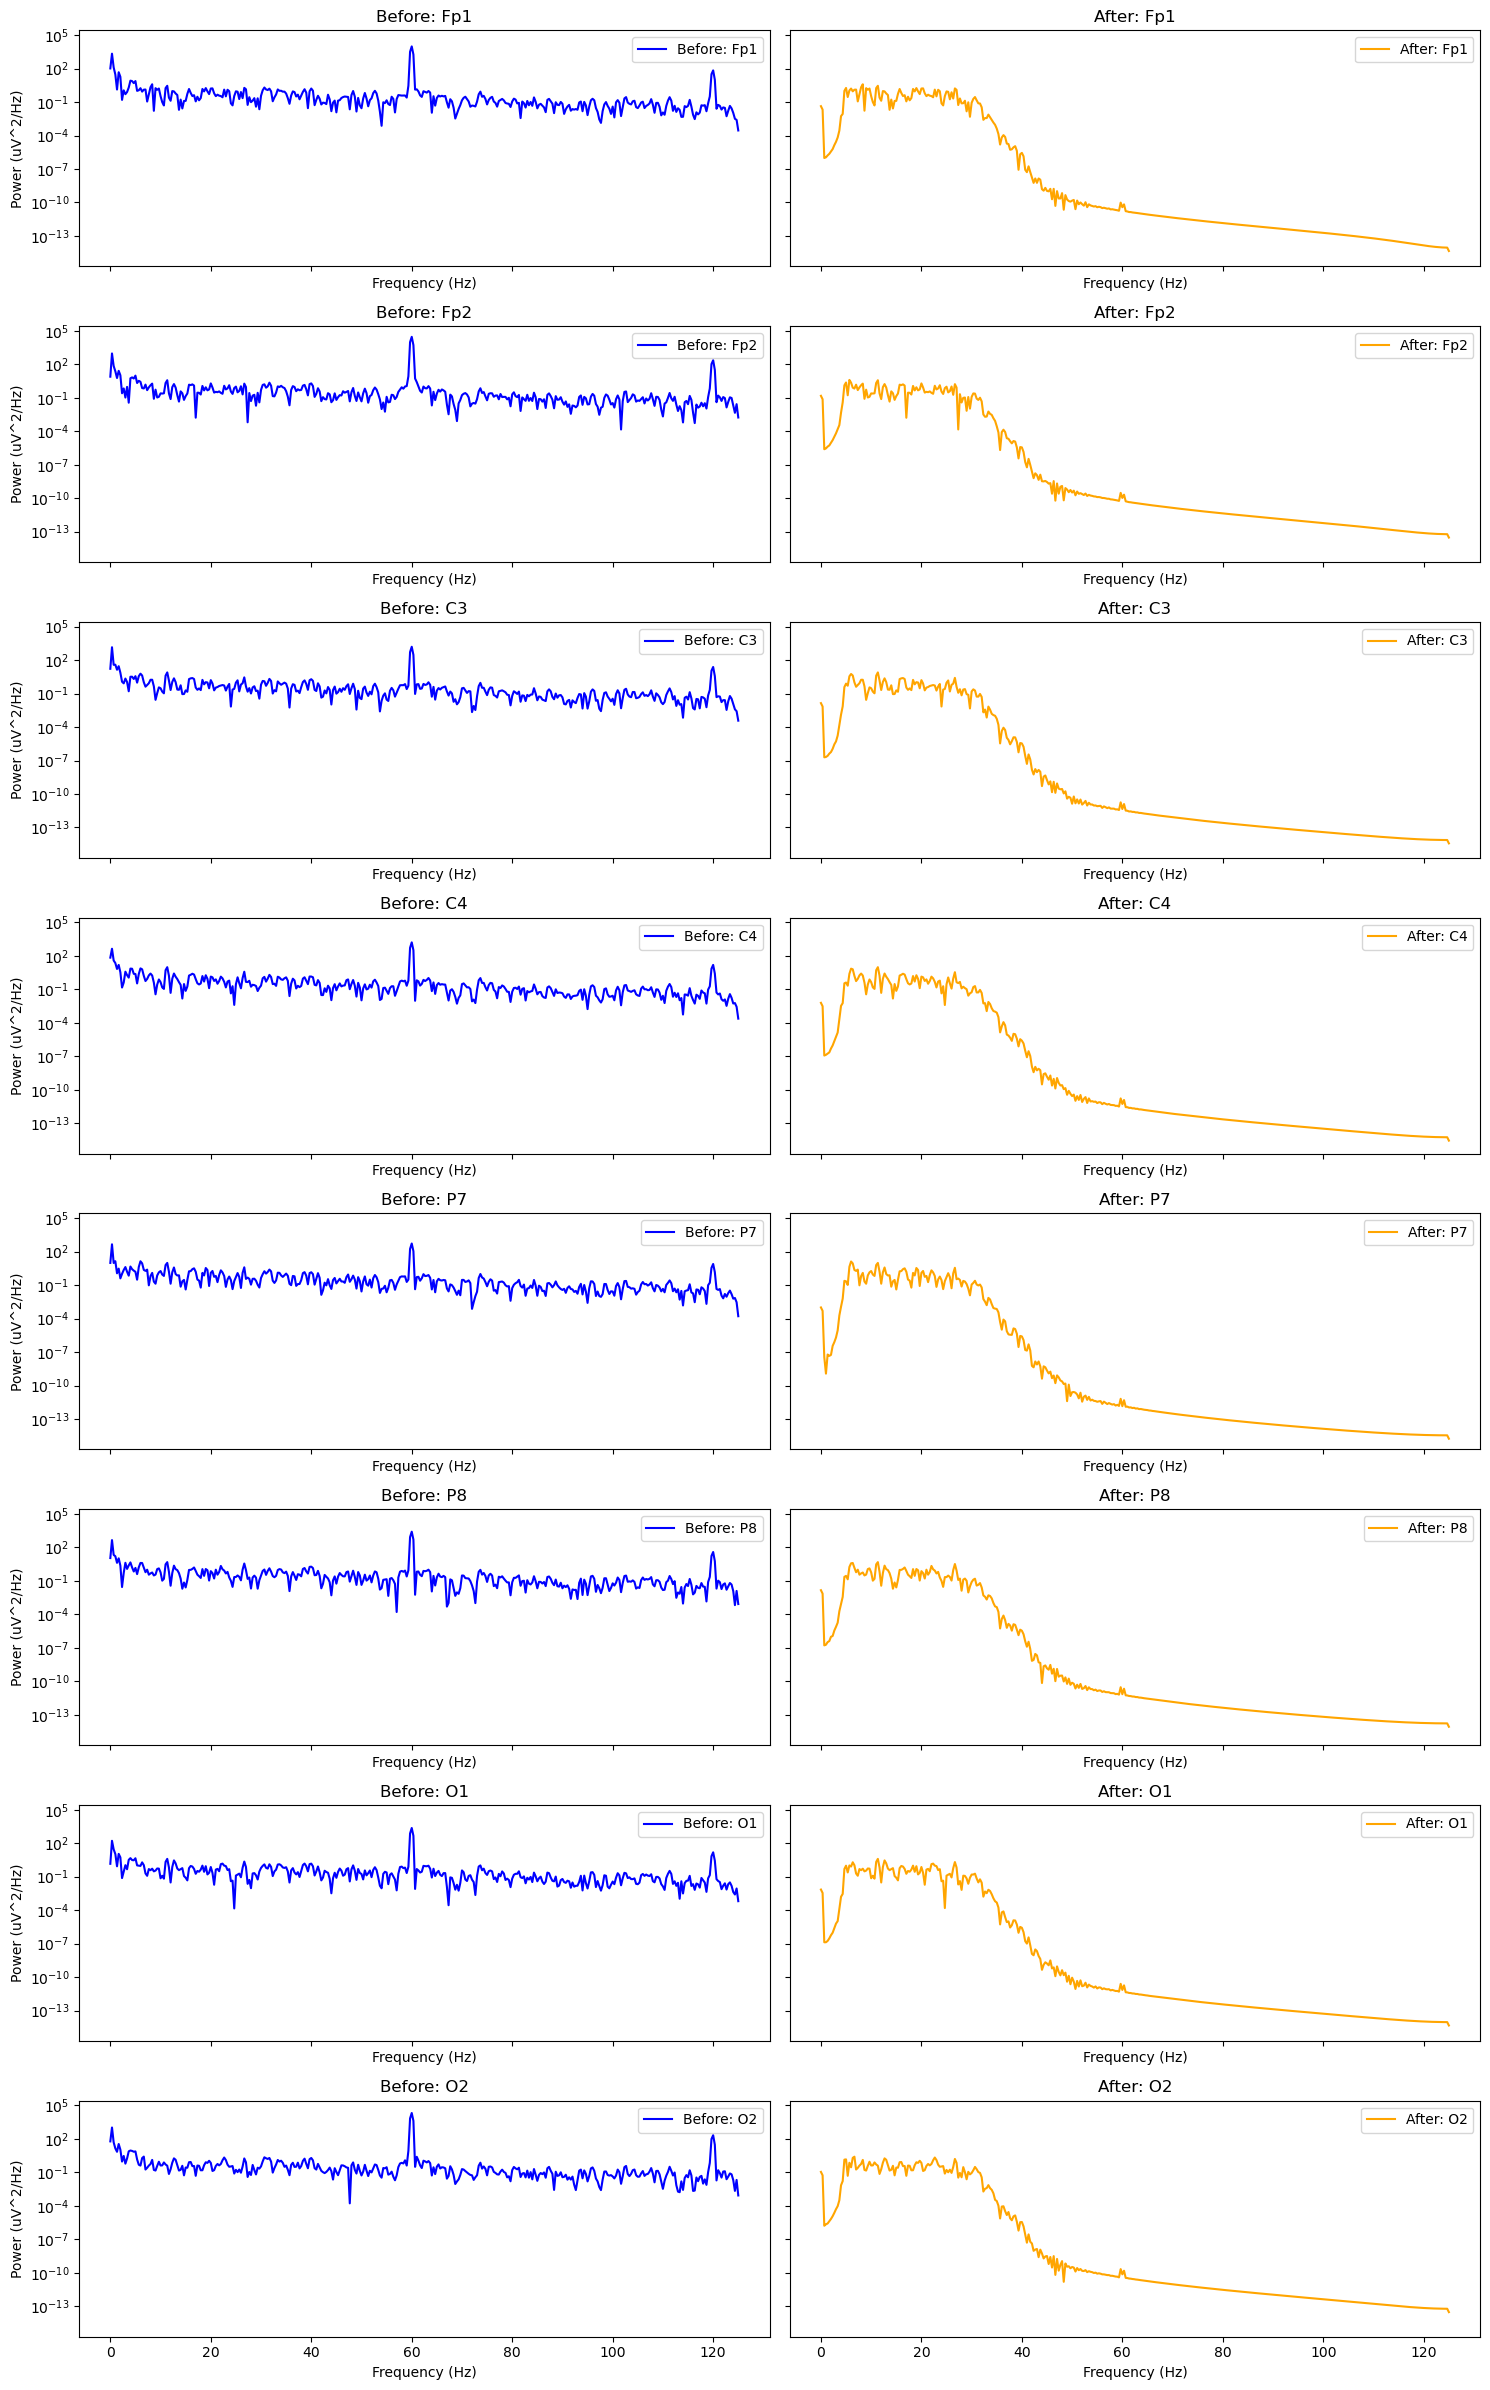

In [12]:
compare_psd_side_by_side(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

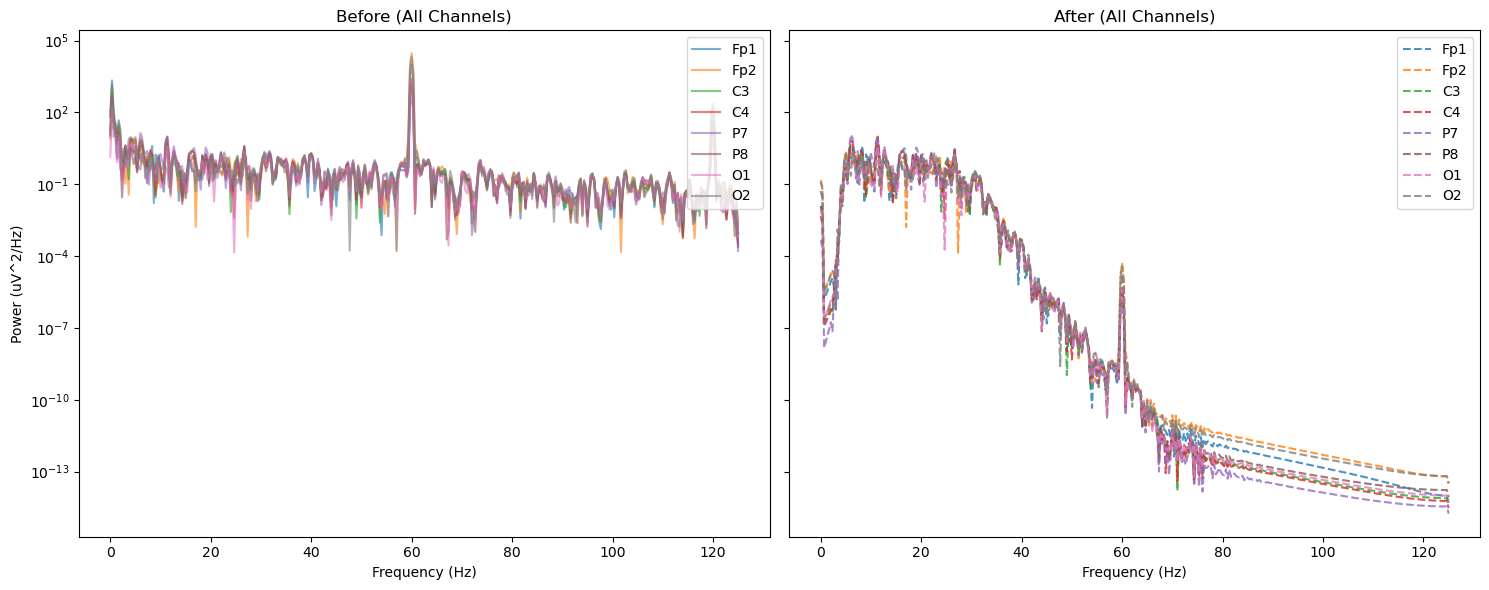

In [14]:
compare_psd_stacked(eeg_data, 
                    filtered_data, 
                    sampling_rate, 
                    channel_names = channel_names,
                    average=False)

c:\Users\surge\Documents\GitHub\BCItoolkit\testing\..\modules\visualization.py:295: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(channel_names, rotation=45, ha='right')
c:\Users\surge\Documents\GitHub\BCItoolkit\testing\..\modules\visualization.py:301: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(channel_names, rotation=45, ha='right')


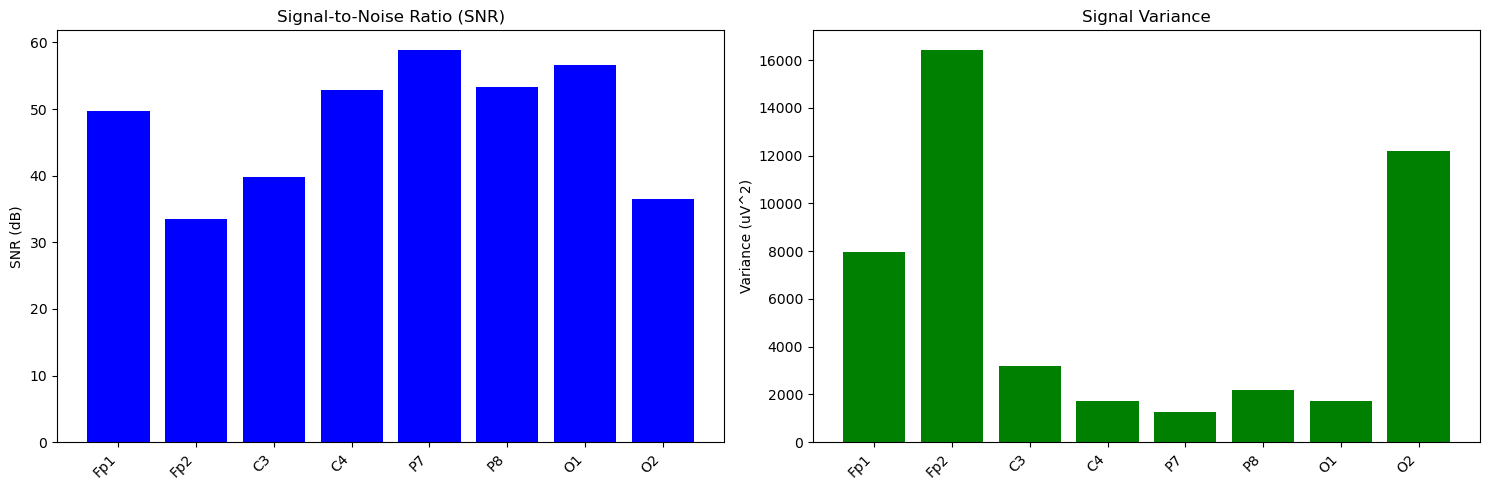

In [14]:
plot_signal_quality(eeg_data, channel_names = channel_names)

### Reference code from `Pipeline_Test_Suite_STREAM_DATA.py`